In [8]:
# Import necessary libraries
import numpy as np
import pandas as pd
import os
from obspy import read
from obspy.signal.filter import bandpass
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define data directories
TRAIN_DATA_DIR = './data/lunar/training/data/S12_GradeA/'
TRAIN_CATALOG_FILE = './data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv'
TEST_DATA_DIR = './data/lunar/test/data/S12_GradeB/'

# Load the training catalog
catalog = pd.read_csv(TRAIN_CATALOG_FILE)


In [9]:
# Function to load seismic data from a file
def load_seismic_data(filename, data_dir=TRAIN_DATA_DIR):
    mseed_file = os.path.join(data_dir, filename + '.mseed')
    st = read(mseed_file)
    tr = st[0]
    data = tr.data
    sampling_rate = tr.stats.sampling_rate
    starttime = tr.stats.starttime.datetime
    return data, sampling_rate, starttime

# Prepare lists to hold data and labels
X = []
y = []

# Parameters for data segmentation
WINDOW_SIZE = 1024  # Number of samples per segment (adjust as needed)
STEP_SIZE = 256     # Step size for sliding window (adjust as needed)
EVENT_WINDOW_LABEL = 1
NO_EVENT_WINDOW_LABEL = 0

# Bandpass filter parameters (adjust as needed)
FREQ_MIN = 0.5  # Hz
FREQ_MAX = 2.0  # Hz

# Load data and labels
for idx, row in catalog.iterrows():
    filename = row['filename']
    arrival_time_rel = row['time_rel(sec)']
    # Load seismic data
    data, sampling_rate, starttime = load_seismic_data(filename)
    # Apply bandpass filter
    data = bandpass(data, FREQ_MIN, FREQ_MAX, sampling_rate, corners=4, zerophase=True)
    # Normalize data
    data = (data - np.mean(data)) / np.std(data)
    # Calculate event sample index
    event_sample_idx = int(arrival_time_rel * sampling_rate)
    # Slide a window over the data
    num_segments = (len(data) - WINDOW_SIZE) // STEP_SIZE + 1
    for i in range(num_segments):
        start_idx = i * STEP_SIZE
        end_idx = start_idx + WINDOW_SIZE
        window_data = data[start_idx:end_idx]
        # Check if the event is within this window
        if event_sample_idx >= start_idx and event_sample_idx < end_idx:
            label = EVENT_WINDOW_LABEL
        else:
            label = NO_EVENT_WINDOW_LABEL
        # Append to lists
        X.append(window_data)
        y.append(label)

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)
print(f'Total segments: {len(X)}')


Total segments: 168377


In [10]:
for idx, row in catalog.iterrows():
    filename = row['filename']
    arrival_time_rel = row['time_rel(sec)']
    # Load seismic data
    data, sampling_rate, starttime = load_seismic_data(filename)
    # Apply bandpass filter
    data = bandpass(data, FREQ_MIN, FREQ_MAX, sampling_rate, corners=4, zerophase=True)
    # Normalize data
    data = (data - np.mean(data)) / np.std(data)
    # Calculate event sample index
    event_sample_idx = int(arrival_time_rel * sampling_rate)
    print(event_sample_idx)
    print(len(data))
    break

486937
572415


In [11]:
# Count the number of samples in each class
unique, counts = np.unique(y, return_counts=True)
print(f'Class distribution before balancing: {dict(zip(unique, counts))}')

# Oversample the minority class
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X.reshape(-1, WINDOW_SIZE), y)

print(f'Class distribution after balancing: {dict(zip(*np.unique(y_resampled, return_counts=True)))}')

# Reshape X for CNN input (samples, timesteps, channels)
X_resampled = X_resampled[..., np.newaxis]


Class distribution before balancing: {0: 168073, 1: 304}
Class distribution after balancing: {0: 168073, 1: 168073}


In [12]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

print(f'Training data shape: {X_train.shape}')
print(f'Validation data shape: {X_val.shape}')


Training data shape: (268916, 1024, 1)
Validation data shape: (67230, 1024, 1)


In [13]:
from tensorflow.keras import models, layers, Input
from tensorflow.keras.models import Model

# Inception Module
def inception_module(x):
    branch1 = layers.Conv1D(32, 1, activation='relu', padding='same')(x)
    
    branch2 = layers.Conv1D(32, 3, activation='relu', padding='same')(x)
    
    branch3 = layers.Conv1D(32, 5, activation='relu', padding='same')(x)
    
    branch4 = layers.MaxPooling1D(3, strides=1, padding='same')(x)
    branch4 = layers.Conv1D(32, 1, activation='relu', padding='same')(branch4)
    
    output = layers.concatenate([branch1, branch2, branch3, branch4], axis=-1)
    return output

# Input Layer
inputs = Input(shape=(WINDOW_SIZE, 1))

# Inception Modules
x = inception_module(inputs)
x = inception_module(x)

# Global Pooling and Output Layer
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

# Model Definition
model = Model(inputs=inputs, outputs=outputs)

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 1024, 1)]            0         []                            
                                                                                                  
 max_pooling1d_2 (MaxPoolin  (None, 1024, 1)              0         ['input_2[0][0]']             
 g1D)                                                                                             
                                                                                                  
 conv1d_8 (Conv1D)           (None, 1024, 32)             64        ['input_2[0][0]']             
                                                                                                  
 conv1d_9 (Conv1D)           (None, 1024, 32)             128       ['input_2[0][0]']       

In [14]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Add callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)


Epoch 1/5
4202/4202 [==============================] - ETA: 0s - loss: 0.6033 - accuracy: 0.6544

MemoryError: Unable to allocate 525. MiB for an array with shape (67230, 1024, 1) and data type float64

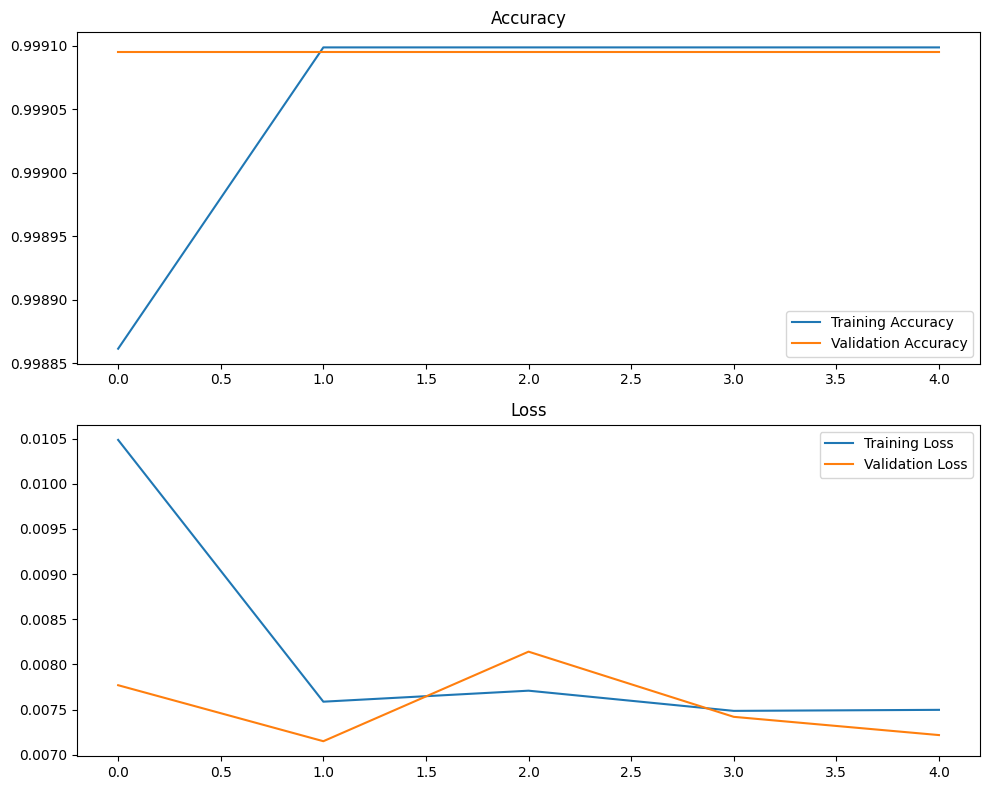

In [81]:
# Plot training and validation accuracy and loss
def plot_history(history):
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))
    # Accuracy plot
    axs[0].plot(history.history['accuracy'], label='Training Accuracy')
    axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[0].set_title('Accuracy')
    axs[0].legend()
    # Loss plot
    axs[1].plot(history.history['loss'], label='Training Loss')
    axs[1].plot(history.history['val_loss'], label='Validation Loss')
    axs[1].set_title('Loss')
    axs[1].legend()
    plt.tight_layout()
    plt.show()

plot_history(history)


In [82]:
# Evaluate on validation data
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

# Classification report
y_pred_prob = model.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()
print(classification_report(y_val, y_pred))

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
print('Confusion Matrix:')
print(cm)


2107/2107 [==============================] - 5s 2ms/step - loss: 0.0072 - accuracy: 0.9991
Validation Accuracy: 99.91%
2107/2107 [==============================] - 5s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     67346
           1       0.00      0.00      0.00        61

    accuracy                           1.00     67407
   macro avg       0.50      0.50      0.50     67407
weighted avg       1.00      1.00      1.00     67407

Confusion Matrix:
[[67346     0]
 [   61     0]]


c:\Users\K-Gen\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\K-Gen\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\K-Gen\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [83]:
# Function to process test data
def process_test_data(test_filename, data_dir=TEST_DATA_DIR):
    # Load data
    data, sampling_rate, starttime = load_seismic_data(test_filename, data_dir)
    # Apply bandpass filter
    data = bandpass(data, FREQ_MIN, FREQ_MAX, sampling_rate, corners=4, zerophase=True)
    # Normalize data
    data = (data - np.mean(data)) / np.std(data)
    # Segment data
    segments = []
    segment_times = []
    num_segments = (len(data) - WINDOW_SIZE) // STEP_SIZE + 1
    for i in range(num_segments):
        start_idx = i * STEP_SIZE
        end_idx = start_idx + WINDOW_SIZE
        window_data = data[start_idx:end_idx]
        segments.append(window_data)
        # Calculate the midpoint time of the window
        window_start_time = starttime + timedelta(seconds=start_idx / sampling_rate)
        window_mid_time = window_start_time + timedelta(seconds=(WINDOW_SIZE / (2 * sampling_rate)))
        segment_times.append(window_mid_time)
    # Convert to numpy array and reshape
    segments = np.array(segments)
    segments = segments[..., np.newaxis]
    return data, segments, segment_times, sampling_rate

# List of test files
test_files = [f.replace('.mseed', '') for f in os.listdir(TEST_DATA_DIR) if f.endswith('.mseed')]

detections_list = []

for test_filename in test_files:
    data, segments, segment_times, sampling_rate = process_test_data(test_filename)
    predictions = model.predict(segments)
    predicted_labels = (predictions > 0.8).astype("int32").flatten()
    avg = abs(np.mean(data))
    event_indices = np.where(predicted_labels == 1)[0]
    
    previous_event_time = None
    previous_time_rel_sec = None
    
    for idx in event_indices:
        event_time = segment_times[idx]
        event_time_str = event_time.strftime('%Y-%m-%dT%H:%M:%S.%f')
        time_rel_sec = (event_time - segment_times[0]).total_seconds()

        dist_to_max = abs(data[int(time_rel_sec * sampling_rate)] - np.max(data))
        dist_to_mean = abs(data[int(time_rel_sec * sampling_rate)] - np.mean(data))
        
        if previous_event_time is not None and (time_rel_sec - previous_time_rel_sec) < 1000:
            avg_time_rel_sec = (previous_time_rel_sec + time_rel_sec) / 2
            avg_event_time = previous_event_time + (event_time - previous_event_time) / 2
            
            detections_list[-1] = {
                'filename': test_filename,
                'time_abs(%Y-%m-%dT%H:%M:%S.%f)': avg_event_time.strftime('%Y-%m-%dT%H:%M:%S.%f'),
                'time_rel(sec)': avg_time_rel_sec
            }
        else:
                detections_list.append({
                    'filename': test_filename,
                    'time_abs(%Y-%m-%dT%H:%M:%S.%f)': event_time_str,
                    'time_rel(sec)': time_rel_sec
                })
        
        previous_event_time = event_time
        previous_time_rel_sec = time_rel_sec



# Convert the list of detections to a DataFrame
detections = pd.DataFrame(detections_list)


140/140 [==============================] - 0s 2ms/step


In [84]:
# Save the detections to a CSV file
detections.to_csv('S12_Grade_B_multi.csv', index=False)
print('Detections saved to seismic_event_detections.csv')


Detections saved to seismic_event_detections.csv
